In [1]:
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.manifold import TSNE
import umap
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV,train_test_split
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn import svm
from sklearn.svm import SVC  
from sklearn.model_selection import GridSearchCV

In [2]:
df1= pd.read_csv(r"F:\UOH_Final Project\NID\UNSW_NB15_Trg_Set.csv")

In [3]:
df1.shape

(175341, 45)

In [4]:
df1.columns

Index(['id', 'dur', 'proto', 'service', 'state', 'spkts', 'dpkts', 'sbytes',
       'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss',
       'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin',
       'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth',
       'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm',
       'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm',
       'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm',
       'ct_srv_dst', 'is_sm_ips_ports', 'attack_cat', 'label'],
      dtype='object')

# ELEMENTARY EDA

<AxesSubplot:>

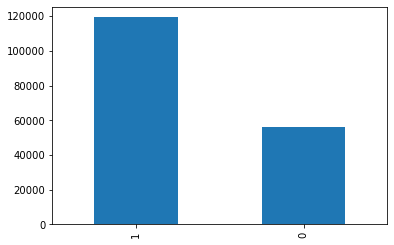

In [5]:
#df1 DataFrame contains all the columns and rows from UNSW_NB15_Trg_Set
# label:1  represent unusual data transfer / 'Attack'
# Label:0  represent normal data transfer
# Barchart for Attack & Normal data transfers
df1.loc[:,'label'].value_counts().plot.bar()


In [6]:
#Check for null values in the DF1 data frame 
pd.set_option('display.max_columns',None)
pd.DataFrame(df1.isna().sum().to_dict(), index=[0])

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [7]:
# Exploring the various data types in the DF1 and their counts
df1.dtypes.value_counts()

int64      30
float64    11
object      4
dtype: int64

In [8]:
#df2 DataFrame contains only the data points representing Class Label: 1
df2=df1[df1.loc[:,'label']==1]

In [9]:
# Sagregating the Attack Categories
df2.loc[:,'attack_cat'].value_counts()

Generic           40000
Exploits          33393
Fuzzers           18184
DoS               12264
Reconnaissance    10491
Analysis           2000
Backdoor           1746
Shellcode          1133
Worms               130
Name: attack_cat, dtype: int64

<AxesSubplot:>

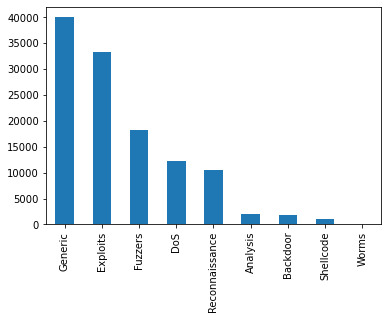

In [10]:
#Attack categories bar chart
df2.loc[:,'attack_cat'].value_counts().plot.bar()

In [11]:
#Listing  the Categorical Features in DF1 
cat=df1.select_dtypes(include=['object'])
cat.columns

Index(['proto', 'service', 'state', 'attack_cat'], dtype='object')

In [12]:
# Copying the Categorical features in to DataFrame Xcat
Xcat=df1[['proto','service','state']]

In [13]:
# Copying the Class label& attacke categories  to DataFrame y, y1 
# Dropping the id column, categorical columns and label columns from DataFrame X. 
# DataFrame X contains only numerical columns.
y=df1.loc[:,'label']
y1=df1.loc[:,'attack_cat']
X= df1.drop(['id','label','attack_cat','proto','service','state'],axis=1)


In [14]:
#Sanity check :  number of columns and column names of DataFrame X
X.columns

Index(['dur', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sttl', 'dttl',
       'sload', 'dload', 'sloss', 'dloss', 'sinpkt', 'dinpkt', 'sjit', 'djit',
       'swin', 'stcpb', 'dtcpb', 'dwin', 'tcprtt', 'synack', 'ackdat', 'smean',
       'dmean', 'trans_depth', 'response_body_len', 'ct_srv_src',
       'ct_state_ttl', 'ct_dst_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm',
       'ct_dst_src_ltm', 'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd',
       'ct_src_ltm', 'ct_srv_dst', 'is_sm_ips_ports'],
      dtype='object')

In [15]:
X.shape

(175341, 39)

In [16]:
#Sanity check :  number of columns and column names of DataFrame Xcat
Xcat.columns

Index(['proto', 'service', 'state'], dtype='object')

In [17]:
Xcat.shape

(175341, 3)

In [18]:
# Finding the number of different types of protocols under 'proto', column. This will be useful in predicting and crosschecking
# the size of the DataFrame X, after OneHot Encoding. 
Clms_after_OneHotEncoding=len(Xcat['proto'].value_counts())+len(Xcat['service'].value_counts())+len(Xcat['state'].value_counts())
Clms_after_OneHotEncoding

155

In [19]:
# Label Encoding applied on DataFrame 'Xcat' first, then OneHotEncoding. 

Xlb = Xcat.apply(LabelEncoder().fit_transform)
Xlb.shape

(175341, 3)

In [20]:
oh=OneHotEncoder()
ohe = oh.fit_transform(Xlb).toarray()
ohe.shape

(175341, 155)

In [21]:
#DataFrame Xoh contains OneHotEncoded equivalent for the DataFrame Xcat, which has 3 categorical features. 
Xoh=pd.DataFrame(ohe)


In [22]:
Xoh.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
Xlb.head()

,proto,service,state
0,113,0,2
1,113,0,2
2,113,0,2
3,113,3,2
4,113,0,2


In [24]:
# DataFrame X:  Contains only Numerical Features ie 39 columns
# DataFrame Xcat:  Contains only Cateroical Features without Encoding , ie 3 columns
# DataFrame Xoh:  OneHot Encoded equivalent for Xcat , ie 155 columns
# DataFrame X1:  Contains both Numerical (X)+OneHot Encoded Features(Xoh), intotal having 194 Columns
# DataFrame X2:  Applied StandardScaler on X 

In [25]:
# Applying Standard Scaling operation on X2 DataFrame 
scaler=StandardScaler()
temp=scaler.fit_transform(X)
X2=pd.DataFrame(temp,columns=X.columns)
X2.shape

(175341, 39)

In [26]:
#Combining the DataFrames X and Xoh using Outer Join 
frames=[X2,Xoh]
X1=pd.concat(frames,axis=1,join='outer')

In [27]:
#Santy Check 
X1.head(10)

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154
0,-0.191029,-0.104456,-0.135769,-0.049134,-0.102726,-0.576371,0.703839,1.578100,-0.389897,-0.273700,-0.075040,-0.131759,-0.132788,-0.080885,-0.109997,-0.145905,1.092456,-0.256392,0.911123,1.103244,-0.521660,-0.484346,-0.503014,-0.458048,-0.314240,-0.136415,-0.039557,-0.775991,-1.366486,-0.645013,-0.544736,-0.554373,-0.705529,-0.118590,-0.118590,-0.189768,-0.715714,-0.753074,-0.126508,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.109485,-0.046014,0.172599,-0.046410,0.188544,-0.576345,-1.141901,1.560002,-0.389928,-0.069233,-0.044739,0.190621,-0.129251,-0.073735,-0.109302,0.192913,1.092456,0.331031,1.557251,1.103244,-0.521660,-0.484346,-0.503014,-0.414076,3.800869,-0.136415,-0.039557,3.147666,-0.318711,-0.645013,-0.544736,-0.554373,-0.614256,-0.118590,-0.118590,-0.189768,-0.715714,-0.288257,-0.126508,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.040699,-0.089845,-0.026933,-0.048527,-0.012133,-0.576734,-1.141901,1.560002,-0.389964,-0.252044,-0.059890,-0.017978,-0.104126,0.014711,0.271392,2.663504,1.092456,0.846258,1.472854,1.103244,0.888444,0.931748,0.742202,-0.443391,2.709185,-0.136415,-0.039557,-0.215468,-0.318711,-0.520827,-0.544736,-0.554373,-0.522983,-0.118590,-0.118590,-0.189768,-0.595543,-0.288257,-0.126508,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.049729,-0.060624,-0.063212,-0.047016,-0.098563,-0.576737,-1.141901,1.560002,-0.389958,-0.275821,-0.059890,-0.074868,-0.115034,0.002046,-0

<AxesSubplot:>

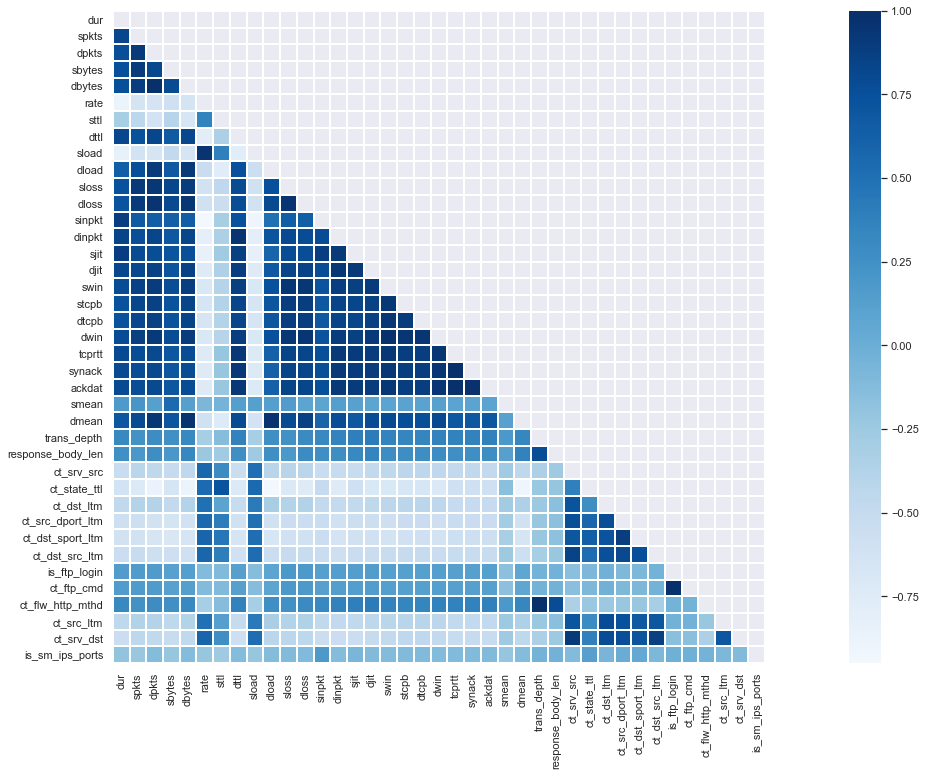

In [28]:
# Computing the Correlation Matrix for identifying if there are any featueres with high correlation
corr=X2.corr('spearman')
sns.set_theme('notebook')

mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(60, 30, as_cmap=True)

plt.figure(figsize=(30,12))
sns.heatmap(corr, mask=mask, cmap='Blues', center=0, square=True, linewidths=1,fmt='.1g', annot=False)

OBSERVATIONS: 
1. UNSW-NB15 training data set is a moderately imbalanced data set. 
2. Sub Classes of "attack_cat" feature is a highly imbalanced data set. 
3. 

# Visualization through PCA

In [29]:
pca=PCA(n_components=2)

In [30]:
pcomp=pca.fit_transform(X2)

In [31]:
print(pcomp)

[[ 2.10477556 -0.58682099]
 [ 2.00568509  1.60494677]
 [ 3.56097154  0.33135571]
 ...
 [-1.59079348 -0.50870769]
 [-5.77174666  1.07959337]
 [-5.85954615  1.10654174]]


In [32]:
pca_df = pd.DataFrame(data=pcomp,columns=['PC1','PC2'])

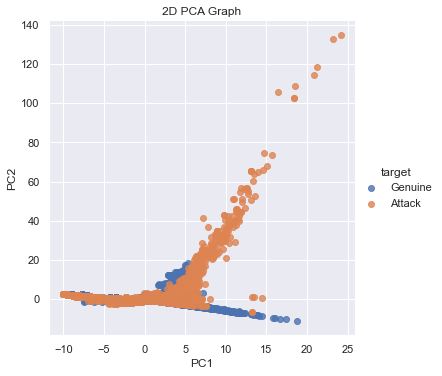

In [33]:
# map target names to PCA features   
target_names = {0:'Genuine',1:'Attack', }
pca_df['target'] = y
pca_df['target'] = pca_df['target'].map(target_names)
 
pca_df.head()

sns.lmplot(x='PC1', y='PC2', data=pca_df, hue='target', fit_reg=False, legend=True)
plt.title('2D PCA Graph')
plt.show()

OBSERVATIONS:
1. It can be seen that there is high degree of overlap between GENUINE Class( 0 ) Data Points and ATTACK Class ( 1 )  Data Points 
2. Hence it is not suggested to use any clustering based techniques for modelling

# TEST DATASET PREPARATION

In [34]:
df3=pd.read_csv(r"F:\UOH_Final Project\NID\UNSW_NB15_Tst_Set.csv")

In [35]:
len(df3.columns)

45

In [36]:
ytst=df3['label']

In [37]:
df3.shape

(82332, 45)

In [38]:
df3.columns

Index(['id', 'dur', 'proto', 'service', 'state', 'spkts', 'dpkts', 'sbytes',
       'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss',
       'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin',
       'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth',
       'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm',
       'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm',
       'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm',
       'ct_srv_dst', 'is_sm_ips_ports', 'attack_cat', 'label'],
      dtype='object')

In [39]:
Xtcat=df3[['proto','service','state']]

In [40]:
#Sanity check :  number of columns and column names of DataFrame X
Xtst=df3.drop(['id','label','attack_cat','proto','service','state'],axis=1)

In [41]:
Xtst.shape

(82332, 39)

In [42]:
Xtcat.columns

Index(['proto', 'service', 'state'], dtype='object')

In [43]:
Xtcat.shape

(82332, 3)

In [44]:
#Sanity check :  number of columns and column names of DataFrame Xcat
Xtst.columns

Index(['dur', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sttl', 'dttl',
       'sload', 'dload', 'sloss', 'dloss', 'sinpkt', 'dinpkt', 'sjit', 'djit',
       'swin', 'stcpb', 'dtcpb', 'dwin', 'tcprtt', 'synack', 'ackdat', 'smean',
       'dmean', 'trans_depth', 'response_body_len', 'ct_srv_src',
       'ct_state_ttl', 'ct_dst_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm',
       'ct_dst_src_ltm', 'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd',
       'ct_src_ltm', 'ct_srv_dst', 'is_sm_ips_ports'],
      dtype='object')

In [45]:
# Finding the number of different types of protocols under 'proto', column. This will be useful in predicting and crosschecking
# the size of the DataFrame X, after OneHot Encoding. 
Clms_after_OneHotEncodingt=len(Xtcat['proto'].value_counts())+len(Xtcat['service'].value_counts())+len(Xtcat['state'].value_counts())
Clms_after_OneHotEncodingt

151

In [46]:
len(Xtcat['proto'].value_counts())

131

In [47]:
len(Xtcat['service'].value_counts())

13

In [48]:
len(Xtcat['state'].value_counts())

7

In [49]:
# Label Encoding applied on DataFrame 'Xcat' first, then OneHotEncoding. 

Xlbt = Xtcat.apply(LabelEncoder().fit_transform)
Xlbt.shape

(82332, 3)

In [50]:
oh=OneHotEncoder()
ohet = oh.fit_transform(Xlbt).toarray()
ohet.shape

(82332, 151)

In [51]:
#DataFrame Xoh contains OneHotEncoded equivalent for the DataFrame Xcat, which has 3 categorical features. 
Xoht=pd.DataFrame(ohet)
Xoht.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [52]:
Xoht['151']=0.0
Xoht['152']=0.0
Xoht['153']=0.0
Xoht['154']=0.0

In [53]:
Xoht.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [54]:
Xoht.shape

(82332, 155)

In [55]:
Xtst.shape

(82332, 39)

In [56]:
scalert=StandardScaler()
tt2=scaler.fit_transform(Xtst)

In [57]:
Xtmpt=pd.DataFrame(tt2,columns=Xtst.columns)
Xtmpt.head()

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports
0,-0.213727,-0.124455,-0.151816,-0.043684,-0.087369,0.057181,0.71944,-0.820395,0.643913,-0.263498,-0.073531,-0.113244,-0.122179,-0.094169,-0.112177,-0.147218,-1.04792,-0.77984,-0.776754,-1.006244,-0.482025,-0.41291,-0.484073,0.520319,-0.475371,-0.173648,-0.04191,-0.680474,0.591021,-0.563660,-0.468312,-0.450186,-0.477994,-0.090857,-0.090617,-0.203143,-0.640033,-0.644190,-0.10607
1,-0.213728,-0.124455,-0.151816,-0.036308,-0.087369,0.286565,0.71944,-0.820395,4.539351,-0.263498,-0.073531,-0.113244,-0.122180,-0.094169,-0.112177,-0.147218,-1.04792,-0.77984,-0.776754,-1.006244,-0.482025,-0.41291,-0.484073,3.556716,-0.475371,-0.173648,-0.04191,-0.680474,0.591021,-0.563660,-0.468312,-0.450186,-0.477994,-0.090857,-0.090617,-0.203143,-0.640033,-0.644190,-0.10607
2,-0.213729,-0.124455,-0.151816,-0.040351,-0.087369,0.791209,0.71944,-0.820395,4.391459,-0.263498,-0.073531,-0.113244,-0.122180,-0.094169,-0.112177,-0.147218,-1.04792,-0.77984,-0.776754,-1.006244,-0.482025,-0.41291,-0.484073,1.892214,-0.475371,-0.173648,-0.04191,-0.590304,0.591021,-0.563660,-0.468312,-0.450186,-0.390391,-0.090857,-0.090617,-0.203143,-0.640033,-0.554273,-0.10607
3,-0.213729,-0.124455,-0.151816,-0.041330,-0.087369,0.566923,0.71944,-0.820395,2.977031,-0.263498,-0.073531,-0.113244,-0.122180,-0.094169,-0.112177,-0.147218,-1.04792,-0.77984,-0.776754,-1.006244,-0.482025,-0.41291,-0.484073,1.489280,-0.475371,-0.173648,-0.04191,-0.590304,0.591021,-0.444868,-0.349115,-0.450186,-0.390391,-0.090857,-0.090617,-0.203143,-0.522990,-0.554273,-0.10607
4,-0.213728,-0.124455,-0.151816,-0.034187,-0.087369,0.118350,0.71944,-0.820395,4.369219,-0.263498,-0.073531,-0.113244,-0.122179,-0.094169,-0.112177,-0.147218,-1.04792,-0.77984,-0.776754,-1.006244,-0.482025,-0.41291,-0.484073,4.429740,-0.475371,-0.173648,-0.04191,-0.590304,0.591021,-0.444868,-0.349115,-0.450186,-0.390391,-0.090857,-0.090617,-0.203143,-0.522990,-0.554273,-0.10607


In [58]:
framest=[Xtmpt,Xoht]
Xft=pd.concat(framest,axis=1,join='outer')

In [59]:
Xft.shape

(82332, 194)

OBSERVATIONS: 
1. Test data set consists of       data points. 
2. The categorical variables of 

# BASELINE MODEL TO EVALUATE FEATURE IMPROTANCE

In [60]:
# instantiate the model (using the default parameters)
lr = LogisticRegression(penalty='l2')
# fit the model with data
lr.fit(X2,y)
y_pred=lr.predict(Xtmpt)

C:\Users\SarathKumar\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [61]:
X2.shape

(175341, 39)

In [62]:
Xtst.shape

(82332, 39)

In [63]:
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(ytst, y_pred)
cnf_matrix

array([[20217, 16783],
       [ 1387, 43945]], dtype=int64)

Text(0.5, 257.44, 'Predicted label')

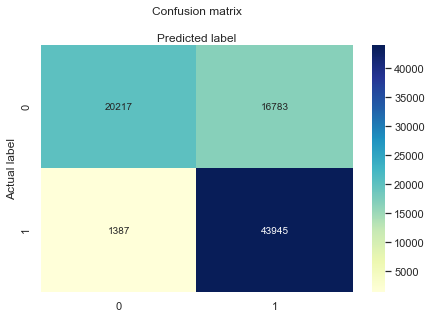

In [64]:
%matplotlib inline
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [65]:
print("Accuracy:",metrics.accuracy_score(ytst, y_pred))
print("Precision:",metrics.precision_score(ytst, y_pred))
print("Recall:",metrics.recall_score(ytst, y_pred))
print("F1 Score:",metrics.f1_score(ytst, y_pred))
print("AUC:",metrics.roc_auc_score(ytst, y_pred))

Accuracy: 0.7793081669338775
Precision: 0.7236365432749309
Recall: 0.9694035118679961
F1 Score: 0.8286818781821611
AUC: 0.7579044586367009


In [66]:
# instantiate the model (using the default parameters)
lr = LogisticRegression(penalty='l2')
# fit the model with data
lr.fit(X1,y)


C:\Users\SarathKumar\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\SarathKumar\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [67]:
X1.shape

(175341, 194)

In [68]:
Xft.shape

(82332, 194)

In [69]:
y_pred=lr.predict(Xft)

C:\Users\SarathKumar\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [70]:
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(ytst, y_pred)
cnf_matrix

array([[18248, 18752],
       [ 3319, 42013]], dtype=int64)

Text(0.5, 257.44, 'Predicted label')

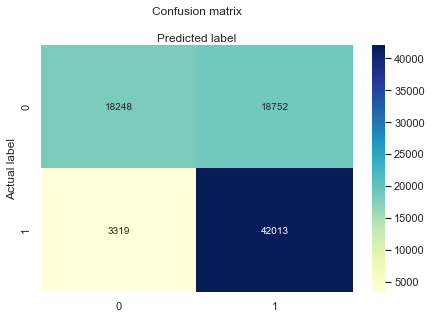

In [71]:
%matplotlib inline
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [72]:
print("Accuracy:",metrics.accuracy_score(ytst, y_pred))
print("Precision:",metrics.precision_score(ytst, y_pred))
print("Recall:",metrics.recall_score(ytst, y_pred))

Accuracy: 0.7319268328232036
Precision: 0.6914013000905126
Recall: 0.9267846113120974


OBSERVATIONS:
1. Base Line model formulated with Logistic Regression as the classifier.
2. Model_1 consists of only 39 Standardized Numeriacl Features, which resulted in better Accuracy, Precision and Recall
3. Model_2 consistns of 39 Standardized Numerical Features +  3 Categorical Features ( resulted in 155 colums after OneHot     Encoding) , which resulted in inferior Accuracy, Precision and Recall as compated to Model_1.
4. After comapring the results from Model_1 & Model_2,  three Categorical Features were omitted for further processing. 

# Feature Selection through Models

LASSO FOR FEATURE SELECTION

In [73]:
X_lso = Lasso(alpha=0.05)
X_lso.fit(X2,y)

Lasso(alpha=0.05)

In [74]:
print(X_lso.coef_)

[ 0.          0.         -0.          0.          0.          0.
  0.21543074  0.02269899  0.         -0.01765608  0.          0.
 -0.         -0.         -0.          0.         -0.         -0.
 -0.         -0.          0.          0.          0.         -0.
  0.          0.          0.          0.          0.06839708  0.
  0.          0.0139414   0.          0.          0.          0.
  0.          0.         -0.        ]


In [75]:
print(X_lso.intercept_)

0.6806223302022916


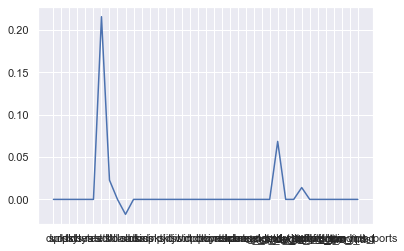

In [76]:
plt.plot(X.columns,X_lso.coef_)
plt.show()

OBSERVATIONS:
1. The output of LASSO Regression contains ony 2 Non Zero components. It can be interpreted as, only 2 features are contibuting in generating the Classification result. All the remaining features are not considered. This makes the Model very simple and underfit model. Hence the LASSO output was not considered in Feature Seleciton. 

# RANDOM FOREST CLASSIFIER FOR FEATURE SELECTION

In [77]:
alpha = [100,200,500,1000,2000]
max_depth = [5, 10]

for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        RFC = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        RFC.fit(X2,y)
        y_pred=RFC.predict(Xtmpt)
        cnf_matrix = metrics.confusion_matrix(ytst, y_pred)
        print(cnf_matrix)
        print("RFC with alpha {} max_depth {} has Accuracy {}:".format(i,j,metrics.accuracy_score(ytst, y_pred)))
        print("RFC with alpha {} max_depth {} has Precision {}:".format(i,j,metrics.precision_score(ytst, y_pred)))
        print("RFC with alpha {} max_depth {} has Recall   {}:".format(i,j,metrics.recall_score(ytst, y_pred)))
        print("RFC with alpha {} max_depth {} has F1_Score   {}:".format(i,j,metrics.f1_score(ytst, y_pred)))
        print("RFC with alpha {} max_depth {} has AUC_Score   {}:".format(i,j,metrics.roc_auc_score(ytst, y_pred)))
        print('_________________________________________________________________________________________________')
       

for n_estimators = 100 and max depth =  5
[[21274 15726]
 [   97 45235]]
RFC with alpha 100 max_depth 5 has Accuracy 0.8078147014526551:
RFC with alpha 100 max_depth 5 has Precision 0.7420317908170798:
RFC with alpha 100 max_depth 5 has Recall   0.99786023118327:
RFC with alpha 100 max_depth 5 has F1_Score   0.8511378924294168:
RFC with alpha 100 max_depth 5 has AUC_Score   0.7864166020781214:
_________________________________________________________________________________________________
for n_estimators = 100 and max depth =  10
[[21326 15674]
 [  112 45220]]
RFC with alpha 100 max_depth 10 has Accuracy 0.8082641014429384:
RFC with alpha 100 max_depth 10 has Precision 0.7426018983807928:
RFC with alpha 100 max_depth 10 has Recall   0.9975293390982087:
RFC with alpha 100 max_depth 10 has F1_Score   0.8513923144992751:
RFC with alpha 100 max_depth 10 has AUC_Score   0.7869538587382936:
_________________________________________________________________________________________________
fo

In [78]:

RFC=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
RFC.fit(X2,y)

RandomForestClassifier(max_depth=10, n_estimators=500, n_jobs=1)

In [79]:
y_pred=RFC.predict(Xtmpt)

In [80]:
feature_imp = pd.Series(RFC.feature_importances_,index=X2.columns).sort_values(ascending=False)
feature_imp * 100

sttl                 18.695254
ct_state_ttl         14.996712
dload                 7.797472
dttl                  5.295879
dmean                 4.316558
rate                  4.096273
sload                 3.944023
synack                3.328470
dur                   2.972725
tcprtt                2.960988
dinpkt                2.758629
sbytes                2.735945
ackdat                2.641929
dbytes                2.564569
ct_srv_dst            2.520532
sinpkt                2.191083
dpkts                 2.165827
smean                 2.084938
ct_dst_src_ltm        1.954727
ct_srv_src            1.498735
spkts                 1.083719
is_sm_ips_ports       0.994526
sloss                 0.972480
sjit                  0.969185
dloss                 0.785933
ct_dst_sport_ltm      0.756442
swin                  0.694463
djit                  0.616081
ct_dst_ltm            0.415984
ct_src_dport_ltm      0.398606
ct_src_ltm            0.185837
stcpb                 0.124783
ct_flw_h

<AxesSubplot:>

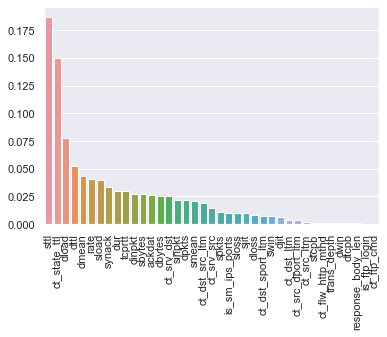

In [81]:
RF_Ftrs_plt=sns.barplot(x=feature_imp.index, y=feature_imp.values)
#RF_Ftrs_plt.title('Feature Weights')
RF_Ftrs_plt.set_xticklabels(RF_Ftrs_plt.get_xticklabels(),rotation = 90)

RF_Ftrs_plt

In [82]:
RFC_Test_CF = metrics.confusion_matrix(ytst, y_pred)


Text(0.5, 257.44, 'Predicted label')

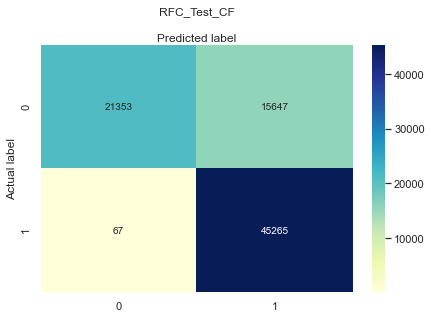

In [83]:
RFC_Test_CF = metrics.confusion_matrix(ytst, y_pred)

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('RFC_Test_CF', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [84]:
print("RFC Test Accuracy:",metrics.accuracy_score(ytst, y_pred))
print("RFC Test Precision:",metrics.precision_score(ytst, y_pred))
print("RFC Test Recall:",metrics.recall_score(ytst, y_pred))
print("RFC Test F1_Score:",metrics.f1_score(ytst, y_pred))
print("RFC Test AUC_Score:",metrics.roc_auc_score(ytst, y_pred))

RFC Test Accuracy: 0.8092236311519215
RFC Test Precision: 0.743222607182148
RFC Test Recall: 0.9984778964087179
RFC Test F1_Score: 0.8521457550855195
RFC Test AUC_Score: 0.7879146238800345


In [85]:
#Dropping the least important 11 features, which are contributing about 1% of the total informaton from X2 and Xtmpt
X2=X2.drop(['ct_src_dport_ltm','ct_dst_ltm','ct_src_ltm','stcpb','trans_depth','ct_flw_http_mthd','dtcpb','response_body_len','dwin','is_ftp_login','ct_ftp_cmd'],axis=1)

Xtmpt=Xtmpt.drop(['ct_src_dport_ltm','ct_dst_ltm','ct_src_ltm','stcpb','trans_depth','ct_flw_http_mthd','dtcpb','response_body_len','dwin','is_ftp_login','ct_ftp_cmd'],axis=1)



In [86]:
#For Test Data set 80000 data points are considered. Remaining 2332 data points are kept reserved 
# for external realtime testing during deployment

df_ext_test=Xtmpt.loc[80001:82332].copy()

Xtmpt=Xtmpt[:80000]

ytst_ext_test=ytst.loc[80001:82332]

ytst=ytst[:80000]





In [87]:
df_ext_test.to_csv('C:\\Users\\SarathKumar\\SLT_Apps\\ext_test_data.csv')
ytst_ext_test.to_csv('C:\\Users\\SarathKumar\\SLT_Apps\\ext_test_data_label.csv')


In [88]:
#Test data set and external test data set (data set to be used during deployment) sanity check
print(len(Xtmpt))
print(len(ytst))
print(len(df_ext_test))
print(len(ytst_ext_test))

80000
80000
2331
2331


# MODELLING

# Naive Bayes

In [ ]:
# DataFrame X:  Contains only Numerical Features ie 39 columns
# DataFrame Xcat:  Contains only Cateroical Features without Encoding , ie 3 columns
# DataFrame Xoh:  OneHot Encoded equivalent for Xcat , ie 155 columns
# DataFrame X1:  Contains both Numerical (X)+OneHot Encoded Features(Xoh), intotal having 194 Columns


# DataFrame X2:  Applied StandardScaler on X. Number of Columns = 28. 
# Class Label for X2 stored in y

# Final Test Datafrme of standardized numerical features Xtmpt. Number of columns = 28. 
# Fianl Test Dataframe label ytst


In [89]:
X2.shape

(175341, 28)

In [ ]:
"""from imblearn.over_sampling import SMOTE
X_resampled, y_resampled = SMOTE().fit_resample(X2,y)"""

In [ ]:
"""X_resampled.shape"""

In [ ]:
"""frm_SMT=[X_resampled, y_resampled]
df_xmt= pd.concat(frm_SMT,axis=1,join='outer')"""

In [ ]:
"""df_xmt.loc[:,'label'].value_counts().plot.bar()"""

In [90]:
len(X2.columns)

28

In [91]:
len(Xtmpt.columns)

28

In [92]:
# Import train_test_split function
from sklearn.model_selection import train_test_split
# Split dataset into training set and test set. Train test ratio 70% (training) and 30% (test).
X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=0.3,random_state=42) 

In [93]:
#Import Gaussian Naive Bayes model
from sklearn.naive_bayes import GaussianNB

#Create a Gaussian Classifier
gnb = GaussianNB()

#Train the model using the training sets
gnb.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = gnb.predict(X_test)



In [94]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn.metrics import confusion_matrix

GNB_Train_CF= confusion_matrix(y_test, y_pred)
print(GNB_Train_CF)

# Model Training Accuracy
print("GNB Model Training Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("GNB Model Training Precision:",metrics.precision_score(y_test,y_pred))
print("GNB Model Training Recall:",metrics.recall_score(y_test, y_pred))
print("GNB Model Training F1_Score:",metrics.f1_score(y_test, y_pred))
print("GNB Model Training AUC_Score:",metrics.roc_auc_score(y_test, y_pred))


[[11088  5684]
 [ 1430 34401]]
GNB Model Training Accuracy: 0.8647605649867878
GNB Model Training Precision: 0.8582013221903455
GNB Model Training Recall: 0.9600904244927577
GNB Model Training F1_Score: 0.9062911639180147
GNB Model Training AUC_Score: 0.8105961304433739


Text(0.5, 257.44, 'Predicted label')

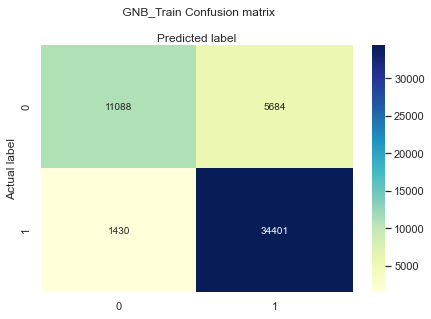

In [95]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(GNB_Train_CF), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title(' GNB_Train Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [96]:

#Train the model using the whole training set X2. Number of columns = 39
gnb.fit(X2,y)

#Predict the response for Test dataset Xtmpt. Number of columns = 39
y_pred = gnb.predict(Xtmpt)
GNB_Test_CF = confusion_matrix(ytst,y_pred)

In [97]:
X2.head()

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,tcprtt,synack,ackdat,smean,dmean,ct_srv_src,ct_state_ttl,ct_dst_sport_ltm,ct_dst_src_ltm,ct_srv_dst,is_sm_ips_ports
0,-0.191029,-0.104456,-0.135769,-0.049134,-0.102726,-0.576371,0.703839,1.578100,-0.389897,-0.273700,-0.075040,-0.131759,-0.132788,-0.080885,-0.109997,-0.145905,1.092456,-0.521660,-0.484346,-0.503014,-0.458048,-0.314240,-0.775991,-1.366486,-0.554373,-0.705529,-0.753074,-0.126508
1,-0.109485,-0.046014,0.172599,-0.046410,0.188544,-0.576345,-1.141901,1.560002,-0.389928,-0.069233,-0.044739,0.190621,-0.129251,-0.073735,-0.109302,0.192913,1.092456,-0.521660,-0.484346,-0.503014,-0.414076,3.800869,3.147666,-0.318711,-0.554373,-0.614256,-0.288257,-0.126508
2,0.040699,-0.089845,-0.026933,-0.048527,-0.012133,-0.576734,-1.141901,1.560002,-0.389964,-0.252044,-0.059890,-0.017978,-0.104126,0.014711,0.271392,2.663504,1.092456,0.888444,0.931748,0.742202,-0.443391,2.709185,-0.215468,-0.318711,-0.554373,-0.522983,-0.288257,-0.126508
3,0.049729,-0.060624,-0.063212,-0.047016,-0.098563,-0.576737,-1.141901,1.560002,-0.389958,-0.275821,-0.059890,-0.074868,-0.115034,0.002046,-0.104906,1.080373,1.092456,-0.521660,-0.484346,-0.503014,-0.414076,-0.232945,-0.775991,-0.318711,-0.554373,-0.522983,-0.753074,-0.126508
4,-0.140417,-0.075235,-0.117630,-0.047554,-0.102057,-0.576617,0.723268,1.560002,-0.389927,-0.275561,-0.044739,-0.112795,-0.129549,-0.012721,-0.056942,-0.120301,1.092456,1.096172,1.154999,0.909954,-0.409190,-0.306498,3.147666,-0.318711,-0.554373,2.854115,2.779535,-0.126508


In [98]:
X2.shape

(175341, 28)

In [99]:
Xft.head()

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154
0,-0.213727,-0.124455,-0.151816,-0.043684,-0.087369,0.057181,0.71944,-0.820395,0.643913,-0.263498,-0.073531,-0.113244,-0.122179,-0.094169,-0.112177,-0.147218,-1.04792,-0.77984,-0.776754,-1.006244,-0.482025,-0.41291,-0.484073,0.520319,-0.475371,-0.173648,-0.04191,-0.680474,0.591021,-0.563660,-0.468312,-0.450186,-0.477994,-0.090857,-0.090617,-0.203143,-0.640033,-0.644190,-0.10607,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.213728,-0.124455,-0.151816,-0.036308,-0.087369,0.286565,0.71944,-0.820395,4.539351,-0.263498,-0.073531,-0.113244,-0.122180,-0.094169,-0.112177,-0.147218,-1.04792,-0.77984,-0.776754,-1.006244,-0.482025,-0.41291,-0.484073,3.556716,-0.475371,-0.173648,-0.04191,-0.680474,0.591021,-0.563660,-0.468312,-0.450186,-0.477994,-0.090857,-0.090617,-0.203143,-0.640033,-0.644190,-0.10607,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.213729,-0.124455,-0.151816,-0.040351,-0.087369,0.791209,0.71944,-0.820395,4.391459,-0.263498,-0.073531,-0.113244,-0.122180,-0.094169,-0.112177,-0.147218,-1.04792,-0.77984,-0.776754,-1.006244,-0.482025,-0.41291,-0.484073,1.892214,-0.475371,-0.173648,-0.04191,-0.590304,0.591021,-0.563660,-0.468312,-0.450186,-0.390391,-0.090857,-0.090617,-0.203143,-0.640033,-0.554273,-0.10607,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.213729,-0.124455,-0.151816,-0.041330,-0.087369,0.566923,0.71944,-0.820395,2.977031,-0.263498,-0.073531,-0.113244,-0.122180,-0.094169,-0.1121

In [100]:
Xtmpt.shape

(80000, 28)

In [102]:
# Model Test Accuracy
print("GNB Model Test Accuracy:",metrics.accuracy_score(ytst, y_pred))
print("GNB Model Test precision:",metrics.precision_score(ytst, y_pred))
print("GNB Model Test recall:",metrics.recall_score(ytst,y_pred))
print("GNB Model Test F1_Score:",metrics.f1_score(ytst,y_pred))
print("GNB Model Test AUC_Score:",metrics.roc_auc_score(ytst,y_pred))

FPR_GNB, TPR_GNB, _ = metrics.roc_curve(ytst,y_pred)
GNB_AUC = round(metrics.roc_auc_score(ytst,y_pred), 4)

GNB Model Test Accuracy: 0.43365
GNB Model Test precision: 1.0
GNB Model Test recall: 0.0005294273360981205
GNB Model Test F1_Score: 0.0010582943822206544
GNB Model Test AUC_Score: 0.500264713668049


Text(0.5, 257.44, 'Predicted label')

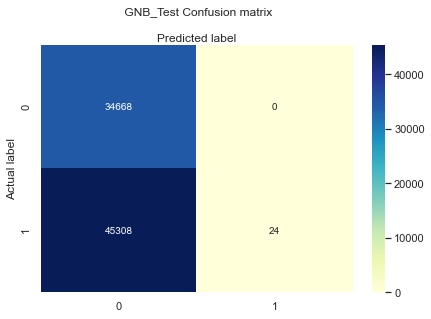

In [103]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(GNB_Test_CF), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title(' GNB_Test Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

# KNN

In [104]:
# Import train_test_split function
from sklearn.model_selection import train_test_split
# Split dataset into training set and test set. Train test ratio 70% (training) and 30% (test).
X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=0.3,random_state=42) 

In [105]:
print('X_train length:',len(X_train))
print('X_test length :',len(X_test))
print('y_train length:',len(y_train))
print('y_test length :',len(y_test))
print('y_pred length :',len(y_pred))
print('X test dataset length:',len(Xtmpt))
#print('y pred dataset length:',len(ypred))
print('y test dataset length:',len(ytst))



X_train length: 122738
X_test length : 52603
y_train length: 122738
y_test length : 52603
y_pred length : 80000
X test dataset length: 80000
y test dataset length: 80000


for alpha = 3
[[14988  1784]
 [ 1427 34404]]
KNN with alpha = 3 has Train Accuracy = 0.9389578541147843:
KNN with alpha = 3 has Train Precision = 0.9507018901293246:
KNN with alpha = 3 has Train Recall = 0.9601741508749407:
KNN with alpha = 3 has Train F1_Score = 0.9554145433843847:
KNN with alpha = 3 has Train AUC_Score = 0.9269031975457461:
[[25648  9020]
 [ 3156 42176]]
KNN with alpha = 3 has Test Accuracy = 0.8478:
KNN with alpha = 3 has Precision = 0.8238143604969138:
KNN with alpha = 3 has Recall = 0.9303803053030971:
KNN with alpha = 3 has F1_Score = 0.8738604342781369:
KNN with alpha = 3 has AUC_Score = 0.8350990023111768:
_________________________________________________________________________________________________
for alpha = 5
[[14903  1869]
 [ 1279 34552]]
KNN with alpha = 5 has Train Accuracy = 0.9401555044389104:
KNN with alpha = 5 has Train Precision = 0.9486834518546993:
KNN with alpha = 5 has Train Recall = 0.96430465239597:
KNN with alpha = 5 has Train F1_Score = 0

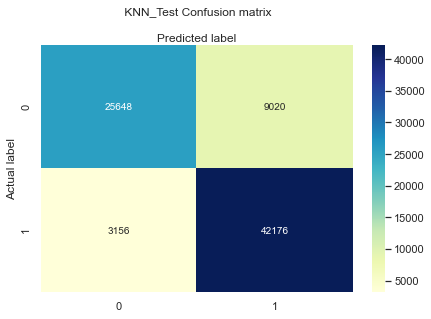

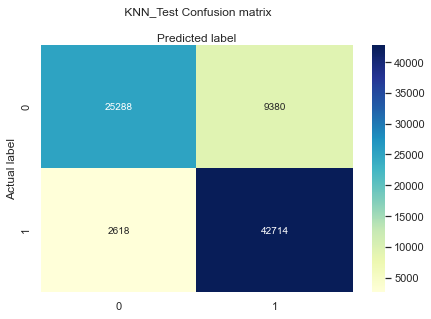

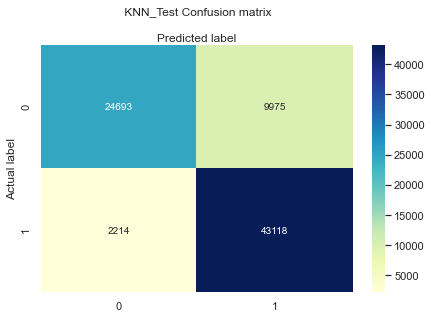

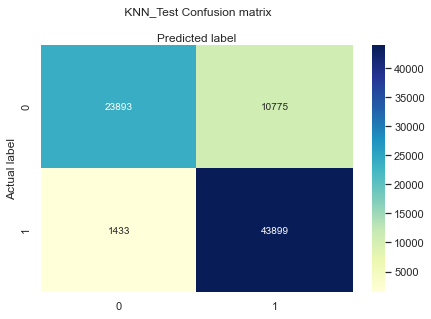

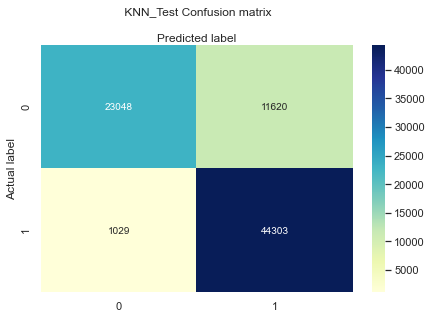

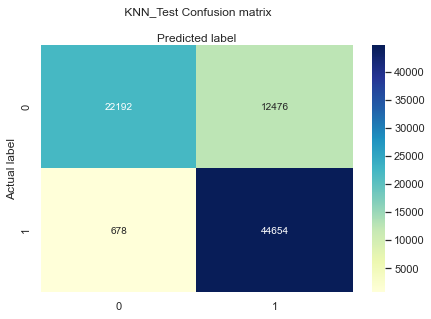

In [106]:
from sklearn.neighbors import KNeighborsClassifier
    
alpha = [3,5,11,25,51,101]

for i in alpha:
    print("for alpha =", i)
    KNN = KNeighborsClassifier(n_neighbors=i)
    KNN.fit(X_train,y_train)
    y_pred=KNN.predict(X_test)
    KNN_Train_CF= confusion_matrix(y_test,y_pred)
    print( KNN_Train_CF)
    print("KNN with alpha = {} has Train Accuracy = {}:".format(i,metrics.accuracy_score(y_test, y_pred)))
    print("KNN with alpha = {} has Train Precision = {}:".format(i,metrics.precision_score(y_test, y_pred)))
    print("KNN with alpha = {} has Train Recall = {}:".format(i,metrics.recall_score(y_test, y_pred)))
    print("KNN with alpha = {} has Train F1_Score = {}:".format(i,metrics.f1_score(y_test, y_pred)))
    print("KNN with alpha = {} has Train AUC_Score = {}:".format(i,metrics.roc_auc_score(y_test, y_pred)))
    ypred=KNN.predict(Xtmpt)
    KNN_Test_CF = metrics.confusion_matrix(ytst, ypred)
    print( KNN_Test_CF)
    print("KNN with alpha = {} has Test Accuracy = {}:".format(i,metrics.accuracy_score(ytst, ypred)))
    print("KNN with alpha = {} has Precision = {}:".format(i,metrics.precision_score(ytst, ypred)))
    print("KNN with alpha = {} has Recall = {}:".format(i,metrics.recall_score(ytst, ypred)))
    print("KNN with alpha = {} has F1_Score = {}:".format(i,metrics.f1_score(ytst, ypred)))
    print("KNN with alpha = {} has AUC_Score = {}:".format(i,metrics.roc_auc_score(ytst, ypred)))
    
    class_names=[0,1] # name  of classes
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    # create heatmap
    sns.heatmap(pd.DataFrame(KNN_Test_CF), annot=True, cmap="YlGnBu" ,fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title(' KNN_Test Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    print('_________________________________________________________________________________________________')
    
KNN = KNeighborsClassifier(n_neighbors=5)
KNN.fit(X_train,y_train)
ypred=KNN.predict(Xtmpt)
KNN_Test_CF = metrics.confusion_matrix(ytst, ypred)
FPR_KNN5, TPR_KNN5, _ = metrics.roc_curve(ytst,ypred)
KNN5_AUC = round(metrics.roc_auc_score(ytst,ypred), 4)
       


In [151]:
KNN = KNeighborsClassifier(n_neighbors=5)
KNN_Clsfr=KNN.fit(X_train,y_train)

ypred=KNN.predict(Xtmpt)

FPR_KNN, TPR_KNN, _ = metrics.roc_curve(ytst,ypred)
KNN_AUC = round(metrics.roc_auc_score(ytst,ypred), 4)

# pickling the model
import pickle
pickle_out = open("KNN_Clsfr.pkl", "wb")
pickle.dump(KNN_Clsfr, pickle_out)
pickle_out.close()

KNN with alpha = 5 has Test Accuracy = 0.616044616044616:
_________________________________________________________________________________________________


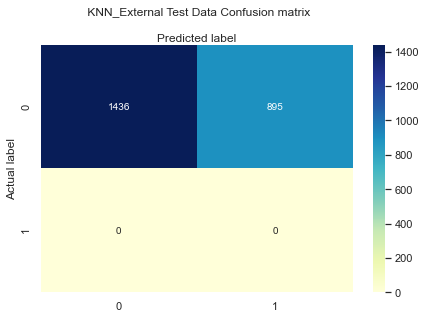

In [108]:
ypred_ext_test=KNN.predict(df_ext_test)
KNN_Ext_Test_CF = metrics.confusion_matrix(ytst_ext_test,ypred_ext_test)
print("KNN with alpha = 5 has Test Accuracy = {}:".format(metrics.accuracy_score(ytst_ext_test,ypred_ext_test)))

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(KNN_Ext_Test_CF), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title(' KNN_External Test Data Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
print('_________________________________________________________________________________________________')

# Logistic Regression

In [ ]:
# DataFrame X:  Contains only Numerical Features ie 39 columns
# DataFrame Xcat:  Contains only Cateroical Features without Encoding , ie 3 columns
# DataFrame Xoh:  OneHot Encoded equivalent for Xcat , ie 155 columns
# DataFrame X1:  Contains both Numerical (X)+OneHot Encoded Features(Xoh), intotal having 194 Columns


# DataFrame X2:  Applied StandardScaler on X. Number of Columns = 39. 
# Class Label for X2 stored in y

# Final Test Datafrme of standardized numerical features Xtmpt. Number of columns = 39. 
# Final Test Dataframe label ytst


In [110]:
# Import train_test_split function
from sklearn.model_selection import train_test_split
# Split dataset into training set and test set. Train test ratio 70% (training) and 30% (test).
X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=0.3,random_state=42) 

print('X_train length:',len(X_train))
print('X_test length :',len(X_test))
print('y_train length:',len(y_train))
print('y_test length :',len(y_test))
print('y_pred length :',len(y_pred))
print('X test dataset length:',len(Xtmpt))
print('y pred dataset length:',len(ypred))
print('y test dataset length:',len(ytst))



X_train length: 122738
X_test length : 52603
y_train length: 122738
y_test length : 52603
y_pred length : 52603
X test dataset length: 80000
y pred dataset length: 80000
y test dataset length: 80000


In [111]:
import warnings
warnings.filterwarnings('ignore')

param_grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}    # Considering both L1 and L2 regualerizations
LR=LogisticRegression()
LR_With_CV=GridSearchCV(LR,param_grid,cv=10)
LR_With_CV.fit(X_train,y_train)

print("Optimized HyperParameters: ",LR_With_CV.best_params_)
print("Train Accuracy :",LR_With_CV.best_score_)



Optimized HyperParameters:  {'C': 1.0, 'penalty': 'l2'}
Train Accuracy : 0.9280744538847301


In [112]:
LR_With_CV_Train=LogisticRegression(C=1.0,penalty="l2")
LR_With_CV_Train.fit(X_train,y_train)
y_pred=LR_With_CV_Train.predict(X_test)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
print(cnf_matrix)
print("LR Train DataSet Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("LR Train DataSet Precision:",metrics.precision_score(y_test, y_pred))
print("LR Train DataSet Recall:",metrics.recall_score(y_test, y_pred))
print("LR Train DataSet F1_Score:",metrics.f1_score(y_test, y_pred))
print("LR Train DataSet AUC_Score:",metrics.roc_auc_score(y_test, y_pred))

[[13298  3474]
 [  383 35448]]
LR Train DataSet Accuracy: 0.9266771857118415
LR Train DataSet Precision: 0.9107445660551873
LR Train DataSet Recall: 0.9893109318746337
LR Train DataSet F1_Score: 0.9484034085588539
LR Train DataSet AUC_Score: 0.8910899996840376


In [113]:
ypred=LR_With_CV_Train.predict(Xtmpt)
LR_Test_CF = metrics.confusion_matrix(ytst, ypred)
print(LR_Test_CF)
FPR_LR, TPR_LR, _ = metrics.roc_curve(ytst,ypred)
LR_AUC = round(metrics.roc_auc_score(ytst,ypred), 4)
print("LR Test DataSet Accuracy:",metrics.accuracy_score(ytst, ypred))
print("LR Test DataSet Precision:",metrics.precision_score(ytst, ypred))
print("LR Test DataSet Recall:",metrics.recall_score(ytst, ypred))
print("LR Test DataSet F1_Score:",metrics.f1_score(ytst, ypred))
print("LR Test DataSet AUC_Score:",metrics.roc_auc_score(ytst, ypred))

[[19519 15149]
 [ 1962 43370]]
LR Test DataSet Accuracy: 0.7861125
LR Test DataSet Precision: 0.7411268135135597
LR Test DataSet Recall: 0.9567193152739787
LR Test DataSet F1_Score: 0.8352350964362404
LR Test DataSet AUC_Score: 0.7598728686673344


_________________________________________________________________________________________________


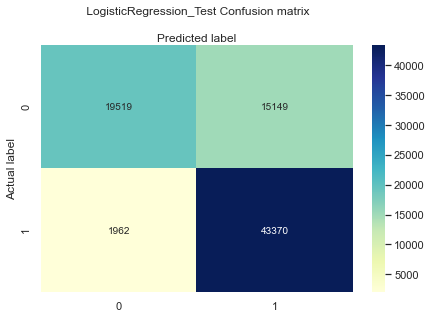

In [114]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(LR_Test_CF), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title(' LogisticRegression_Test Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
print('_________________________________________________________________________________________________')
       


# SVM CLASSIFIER

In [ ]:
'''from sklearn.model_selection import GridSearchCV
grid_parameters = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'sigmoid','linear']}
grid = GridSearchCV(SVC(),grid_parameters,refit=True,verbose=2)
print(grid.fit(X_train,y_train))'''

In [ ]:
'''print(grid.best_estimator_)'''

In [116]:
#Create a svm Classifier
SVM = svm.SVC(kernel='linear',C=0.1,gamma=1) # Linear Kernel

#Train the model using the training sets
SVM.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = SVM.predict(X_test)

# Computing Model Accuracy
print("SVC Train DataSet Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("SVC Train DataSet Presision:",metrics.precision_score(y_test, y_pred))
print("SVC Train DataSet Recall:",metrics.recall_score(y_test, y_pred))
print("SVC Train DataSet F1_Score:",metrics.f1_score(y_test, y_pred))
print("SVC Train DataSet AUC_Score:",metrics.roc_auc_score(y_test, y_pred))

SVC Train DataSet Accuracy: 0.9274946295838641
SVC Train DataSet Presision: 0.9038980698877255
SVC Train DataSet Recall: 0.999860456029695
SVC Train DataSet F1_Score: 0.9494606842816632
SVC Train DataSet AUC_Score: 0.8863778788614967


In [117]:
ypred=SVM.predict(Xtmpt)
SVC_Test_CF = metrics.confusion_matrix(ytst, ypred)
print(cnf_matrix)
FPR_SVC, TPR_SVC, _ = metrics.roc_curve(ytst,ypred)
SVC_AUC = round(metrics.roc_auc_score(ytst,ypred), 4)
print("SVC Test DataSet Accuracy:",metrics.accuracy_score(ytst, ypred))
print("SVC Test DataSet  Precision:",metrics.precision_score(ytst, ypred))
print("SVC Test DataSet Recall:",metrics.recall_score(ytst, ypred))
print("SVC Test DataSet F1_Score:",metrics.f1_score(ytst, ypred))
print("SVC Test DataSet AUC_Score:",metrics.roc_auc_score(ytst, ypred))

[[13298  3474]
 [  383 35448]]
SVC Test DataSet Accuracy: 0.804825
SVC Test DataSet  Precision: 0.7440542671309375
SVC Test DataSet Recall: 0.9993161563575399
SVC Test DataSet F1_Score: 0.8529976651351961
SVC Test DataSet AUC_Score: 0.7749119145696781


_________________________________________________________________________________________________


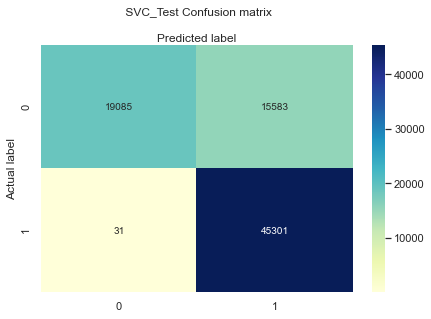

In [118]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(SVC_Test_CF), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title(' SVC_Test Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
print('_________________________________________________________________________________________________')
       


# DECISON TREE CLASSIFIER

In [119]:
from sklearn. tree import DecisionTreeClassifier 
DT = DecisionTreeClassifier(random_state=42)
parameters = {
    'max_depth': [2, 3, 5, 10, 20],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'criterion': ["gini", "entropy"]
}

In [120]:
DT_GS_CV = GridSearchCV(estimator=DT, 
                           param_grid=parameters, 
                           cv=5, n_jobs=-1, verbose=1, scoring = "accuracy")

In [121]:
DT_GS_CV.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 5, 10, 20],
                         'min_samples_leaf': [5, 10, 20, 50, 100]},
             scoring='accuracy', verbose=1)

In [122]:
print("Optimized HyperParameters: ",DT_GS_CV.best_params_)


Optimized HyperParameters:  {'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 20}


In [123]:
print("Training DataSet Accuracy :",DT_GS_CV.best_score_)


Training DataSet Accuracy : 0.9465935556587135


In [124]:
DT_GS_CV2 = DecisionTreeClassifier(max_depth=20,min_samples_leaf=20,criterion='entropy',random_state=42)
DT_GS_CV2.fit(X_train, y_train)
y_pred=DT_GS_CV2.predict(X_test)
DT_Train_CF = metrics.confusion_matrix(y_test, y_pred)
print(DT_Train_CF)
print("DT_Train DataSet Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("DT_Train DataSet Precision:",metrics.precision_score(y_test, y_pred))
print("DT_Train DataSet Recall:",metrics.recall_score(y_test, y_pred))
print("DT_Train DataSet F1_Score:",metrics.f1_score(y_test, y_pred))
print("DT_Train DataSet AUC_Score:",metrics.roc_auc_score(y_test, y_pred))

[[15102  1670]
 [ 1113 34718]]
DT_Train DataSet Accuracy: 0.947094272189799
DT_Train DataSet Precision: 0.9541057491480708
DT_Train DataSet Recall: 0.9689375122100974
DT_Train DataSet F1_Score: 0.9614644345670806
DT_Train DataSet AUC_Score: 0.9346833995584234


In [125]:
ypred=DT_GS_CV2.predict(Xtmpt)
DT_Test_CF = metrics.confusion_matrix(ytst, ypred)
print(DT_Test_CF)
FPR_DT, TPR_DT, _ = metrics.roc_curve(ytst,ypred)
DT_AUC = round(metrics.roc_auc_score(ytst,ypred), 4)
print("DT_Test DataSet Accuracy:",metrics.accuracy_score(ytst, ypred))
print("DT_Test DataSet Precision:",metrics.precision_score(ytst, ypred))
print("DT_Test DataSet Recall:",metrics.recall_score(ytst, ypred))
print("DT_Test DataSet F1_Score:",metrics.f1_score(ytst, ypred))
print("DT_Test DataSet AUC_Score:",metrics.roc_auc_score(ytst, ypred))


[[23226 11442]
 [24926 20406]]
DT_Test DataSet Accuracy: 0.5454
DT_Test DataSet Precision: 0.6407309721175584
DT_Test DataSet Recall: 0.450145592517427
DT_Test DataSet F1_Score: 0.5287898419279605
DT_Test DataSet AUC_Score: 0.5600502971240648


_________________________________________________________________________________________________


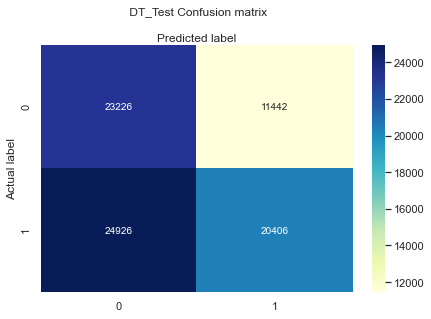

In [126]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(DT_Test_CF), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title(' DT_Test Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
print('_________________________________________________________________________________________________')
       

# RANDOM FOREST CLASSIFIER

In [127]:
RFC2=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
RFC2.fit(X2,y)

RandomForestClassifier(max_depth=10, n_estimators=500, n_jobs=1)

In [128]:
y_pred=RFC2.predict(X_test)
RFC2_Train_CF= metrics.confusion_matrix(y_test, y_pred)
print(RFC2_Train_CF)
print("RFC2_Train DataSet Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("RFC2_Train DataSet Precision:",metrics.precision_score(y_test, y_pred))
print("RFC2_Train DataSet Recall:",metrics.recall_score(y_test, y_pred))
print("RFC2_Train DataSet F1_Score:",metrics.f1_score(y_test, y_pred))
print("RFC2_Train DataSet AUC_Score:",metrics.roc_auc_score(y_test, y_pred))

[[14553  2219]
 [  471 35360]]
RFC2_Train DataSet Accuracy: 0.9488622321920803
RFC2_Train DataSet Precision: 0.9409510630937492
RFC2_Train DataSet Recall: 0.986854957997265
RFC2_Train DataSet F1_Score: 0.9633564909412887
RFC2_Train DataSet AUC_Score: 0.9272755591321884


In [129]:
ypred=RFC2.predict(Xtmpt)
RFC2_Test_CF = metrics.confusion_matrix(ytst, ypred)
print(RFC2_Test_CF)
FPR_RF, TPR_RF, _ = metrics.roc_curve(ytst,ypred)
RF_AUC = round(metrics.roc_auc_score(ytst,ypred), 4)
print("RFC2_Test DataSet Accuracy:",metrics.accuracy_score(ytst, ypred))
print("RFC2_Test DataSet Precision:",metrics.precision_score(ytst, ypred))
print("RFC2_Test DataSet Recall:",metrics.recall_score(ytst, ypred))
print("RFC2_Test DataSet F1_Score:",metrics.f1_score(ytst, ypred))
print("RFC2_Test DataSet AUC_Score:",metrics.roc_auc_score(ytst, ypred))

[[20485 14183]
 [  125 45207]]
RFC2_Test DataSet Accuracy: 0.82115
RFC2_Test DataSet Precision: 0.7611887523152046
RFC2_Test DataSet Recall: 0.9972425659578222
RFC2_Test DataSet F1_Score: 0.8633715933614712
RFC2_Test DataSet AUC_Score: 0.7940666504647771


Text(0.5, 257.44, 'Predicted label')

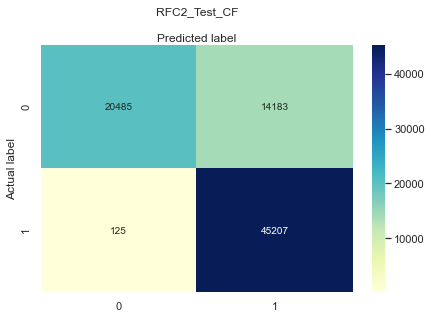

In [130]:

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(RFC2_Test_CF ), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('RFC2_Test_CF', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

# GRADIANT BOOSTING CLASSIFIER

In [131]:
from sklearn.ensemble import GradientBoostingClassifier
GBC = GradientBoostingClassifier()
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt

In [132]:
parameters = {'learning_rate': [0.01,0.02,0.03],
                  'subsample'    : [0.9, 0.5, 0.2],
                  'n_estimators' : [100,500],
                  'max_depth'    : [4,6]
                 }

In [ ]:
#parameter grid for RandomizedSearchCV
'''parameters = {"learning_rate": sp_randFloat(),
                  "subsample"    : sp_randFloat(),
                  "n_estimators" : sp_randInt(100, 1000),
                  "max_depth"    : sp_randInt(4, 10)
                 }'''

In [ ]:
#RandomizedSearchCV 
'''GB_CV = RandomizedSearchCV(estimator=GBC, param_distributions = parameters,
                           cv = 3, n_iter = 10, n_jobs=-1) '''


In [133]:
#GBC with GridSearchCV did not executed. Hence GBC.fit() is used to train the model 
GBC_GCV = GridSearchCV(estimator=GBC, param_grid = parameters, cv = 5, n_jobs=-1)

In [134]:
GBC.fit(X_train, y_train)

GradientBoostingClassifier()

In [135]:
y_pred=GBC.predict(X_test)
GBC_Train_CF= metrics.confusion_matrix(y_test, y_pred)
print(GBC_Train_CF)
print("GB Train DataSet Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("GB Train DataSet Precision:",metrics.precision_score(ytst, ypred))
print("GB Train DataSet Recall:",metrics.recall_score(ytst, ypred))
print("GB Train DataSet F1_Score:",metrics.f1_score(ytst, ypred))
print("GB Train DataSet AUC_Score:",metrics.roc_auc_score(ytst, ypred))

[[14553  2219]
 [  600 35231]]
GB Train DataSet Accuracy: 0.9464099005760128
GB Train DataSet Precision: 0.7611887523152046
GB Train DataSet Recall: 0.9972425659578222
GB Train DataSet F1_Score: 0.8633715933614712
GB Train DataSet AUC_Score: 0.7940666504647771


In [136]:
ypred=GBC.predict(Xtmpt)
GB_Test_CF= metrics.confusion_matrix(ytst, ypred)
print(GB_Test_CF)
FPR_GB, TPR_GB, _ = metrics.roc_curve(ytst,ypred)
GB_AUC = round(metrics.roc_auc_score(ytst,ypred), 4)
print("GB Test DataSet Accuracy:",metrics.accuracy_score(ytst, ypred))
print("GB Test DataSet Precision:",metrics.precision_score(ytst, ypred))
print("GB Test DataSet Recall:",metrics.recall_score(ytst, ypred))
print("GB Test DataSet F1_Score:",metrics.f1_score(ytst, ypred))
print("GB Test DataSet AUC_Score:",metrics.roc_auc_score(ytst, ypred))

[[22146 12522]
 [ 6309 39023]]
GB Test DataSet Accuracy: 0.7646125
GB Test DataSet Precision: 0.7570666407993015
GB Test DataSet Recall: 0.8608267890232065
GB Test DataSet F1_Score: 0.8056194968878061
GB Test DataSet AUC_Score: 0.7498145713894158


Text(0.5, 257.44, 'Predicted label')

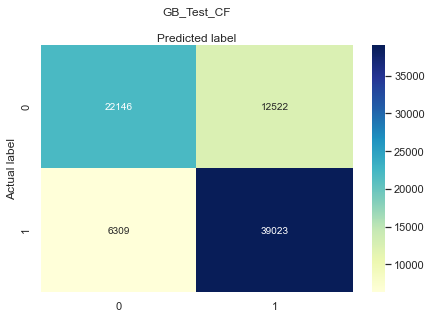

In [137]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(GB_Test_CF ), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('GB_Test_CF', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

# XGBoost CLASSIFIER

In [138]:
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold

In [139]:
# Defining  the search space for various hyperparameters
param_grid = { 
    # Percentage of columns to be randomly samples for each tree.
    "colsample_bytree": [ 0.3, 0.5 , 0.8 ],
    # reg_alpha provides l1 regularization to the weight, higher values result in more conservative models
    "reg_alpha": [0, 0.5, 1, 5],
    # reg_lambda provides l2 regularization to the weight, higher values result in more conservative models
    "reg_lambda": [0, 0.5, 1, 5]
    }
# Set up score
scoring = ['recall']
# Set up the k-fold cross-validation
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

In [140]:
estimator = XGBClassifier(
    objective= 'binary:logistic',
    nthread=4,
    seed=42)
grid_search = GridSearchCV(estimator=estimator, 
                           param_grid=param_grid, 
                           scoring=scoring, 
                           refit='recall', 
                           n_jobs=-1, 
                           cv=kfold, 
                           verbose=0)


In [141]:
grid_result = grid_search.fit(X_train, y_train)
# Print grid search summary
grid_result


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=0, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_c...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None, nthread=4,
              

In [142]:
grid_result.best_params_

{'colsample_bytree': 0.5, 'reg_alpha': 1, 'reg_lambda': 0}

In [143]:
XGB_gs=grid_result.best_estimator_

In [144]:
XGB_gs.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=4, nthread=4, num_parallel_tree=1, predictor='auto',
              random_state=42, reg_alpha=1, ...)

In [145]:
y_pred=XGB_gs.predict(X_test)
XGB_Train_CF= metrics.confusion_matrix(y_test, y_pred)
print(XGB_Train_CF)
print("XGB Train DataSet Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("XGB Train DataSet Precision:",metrics.precision_score(y_test, y_pred))
print("XGB Train DataSet Recall:",metrics.recall_score(y_test, y_pred))
print("XGB Train DataSet F1_Score:",metrics.f1_score(y_test, y_pred))
print("XGB Train DataSet AUC_Score:",metrics.roc_auc_score(y_test, y_pred))

[[15242  1530]
 [  776 35055]]
XGB Train DataSet Accuracy: 0.9561621960724673
XGB Train DataSet Precision: 0.958179581795818
XGB Train DataSet Recall: 0.9783427758086574
XGB Train DataSet F1_Score: 0.9681562085726911
XGB Train DataSet AUC_Score: 0.9435596540622109


In [146]:
ypred=XGB_gs.predict(Xtmpt)
XGB_Test_CF = metrics.confusion_matrix(ytst, ypred)
FPR_XGB, TPR_XGB, _ = metrics.roc_curve(ytst,ypred)
XGB_AUC = round(metrics.roc_auc_score(ytst,ypred), 4)
print(XGB_Test_CF)
print("XGB Test DataSet Accuracy:",metrics.accuracy_score(ytst, ypred))
print("XGB Test DataSet Precision:",metrics.precision_score(ytst, ypred))
print("XGBTest DataSet Recall:",metrics.recall_score(ytst, ypred))
print("XGBTest DataSet F1_Score:",metrics.f1_score(ytst, ypred))
print("XGBTest DataSet AUC_Score:",metrics.roc_auc_score(ytst, ypred))

[[23451 11217]
 [10166 35166]]
XGB Test DataSet Accuracy: 0.7327125
XGB Test DataSet Precision: 0.758165707263437
XGBTest DataSet Recall: 0.7757434042177711
XGBTest DataSet F1_Score: 0.7668538407021751
XGBTest DataSet AUC_Score: 0.7260942704716409


Text(30.5, 0.5, 'Actual label')

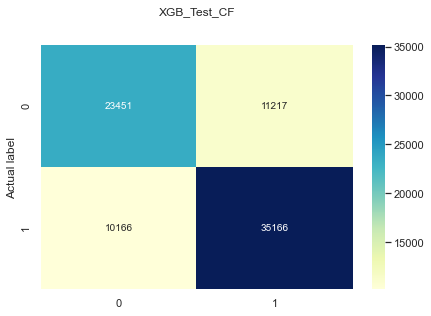

In [147]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(XGB_Test_CF ), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('XGB_Test_CF', y=1.1)
plt.ylabel('Actual label')


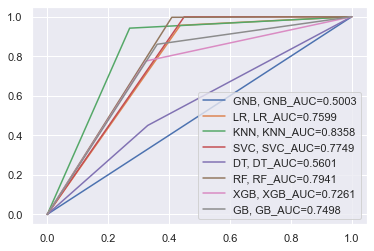

In [152]:
plt.plot(FPR_GNB,TPR_GNB,label="GNB, GNB_AUC="+str(GNB_AUC))
plt.legend()

plt.plot(FPR_LR,TPR_LR,label="LR, LR_AUC="+str(LR_AUC))
plt.legend()

plt.plot(FPR_KNN,TPR_KNN,label="KNN, KNN_AUC="+str(KNN_AUC))
plt.legend()

plt.plot(FPR_SVC,TPR_SVC,label="SVC, SVC_AUC="+str(SVC_AUC))
plt.legend()

plt.plot(FPR_DT,TPR_DT,label="DT, DT_AUC="+str(DT_AUC))
plt.legend()

plt.plot(FPR_RF,TPR_RF,label="RF, RF_AUC="+str(RF_AUC))
plt.legend()


plt.plot(FPR_XGB,TPR_XGB,label="XGB, XGB_AUC="+str(XGB_AUC))
plt.legend()

plt.plot(FPR_GB,TPR_GB,label="GB, GB_AUC="+str(GB_AUC))
plt.legend()

# Deep Learning Models

# Neural Network Model

In [ ]:
# Data Set Details: Sagregation of Numeric and categorical Features;Droping the least useful features etc

# DataFrame X:  Contains only Numerical Features ie 39 columns
# DataFrame Xcat:  Contains only Cateroical Features without Encoding , ie 3 columns
# DataFrame Xoh:  OneHot Encoded equivalent for Xcat , ie 155 columns
# DataFrame X1:  Contains both Numerical (X)+OneHot Encoded Features(Xoh), intotal having 194 Columns


# DataFrame X2:  Applied StandardScaler on X. Number of Columns = 39. 
# Class Label for X2 stored in y

# Final Test Datafrme of standardized numerical features Xtmpt. Number of columns = 39. 
# Fianl Test Dataframe label ytst
# After featurization 11 features were dropped from total 39 features and the data set is X2; no change in y
# Dropping the least important 11 features, which are contributing about 1% of the total informaton from X2 and Xtmpt

#X2,y is the data set for Model trainnig and cross validation

# X2,y id splitted to X_train, y_train, X_test,y_test



In [155]:
#importing all the required standard libraries
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch
import numpy as np
from matplotlib import pyplot as plt

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import confusion_matrix

In [156]:
# X_train, X_test data sets sanity check; Train, Test split done above in "Naive Bayes Model" implementation
print(len(X_train))    # 70% of X2 for model trainnig
print(len(y_train))
print(len(X_test))     # 30% of X2 for model cross validation
print(len(y_test))

122738
122738
52603
52603


In [171]:
#Defining the NN Model. Number of layers and Number of Neurons per layer are treated as hyper parameters. 
# Adam Optimizer chosen as default optimizer with learning rate as hyper parameter
# Relu and Sigmoid are chsoen as activation function, which is also a hyper parameter to choose the best one in each layer
# Softmax layer used to deive the output
def build_model2(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(256, activation='relu', input_dim=28))
    for i in range(hp.Int('layers', 2, 16)):
        model.add(tf.keras.layers.Dense(units=hp.Int('units_' + str(i), 96, 512, step=64),
                                    activation=hp.Choice('act_' + str(i), ['relu', 'sigmoid'])))
    model.add(tf.keras.layers.Dense(1, activation='softmax'))
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-1,1e-2, 1e-3])), 
                  loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [172]:
# From Keras Tuner , RandomSearch used to find out the best set of hyper parameters for the NN Model built with build_model2
tuner2 = RandomSearch(
    build_model2,
    objective = 'val_accuracy',
    max_trials = 3,
    executions_per_trial = 5,
    directory = 'My_NN_Tune2',
    overwrite=True  
)

In [173]:
# Search Space summary list out the Best set of hyperparameters ie Number of layers, Number of Neurons per layer, 
# respective activation function in each layer, Optimizer and learning rate
tuner2.search_space_summary()

Search space summary
Default search space size: 6
layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 16, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 96, 'max_value': 512, 'step': 64, 'sampling': None}
act_0 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'sigmoid'], 'ordered': False}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 96, 'max_value': 512, 'step': 64, 'sampling': None}
act_1 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'sigmoid'], 'ordered': False}
learning_rate (Choice)
{'default': 0.1, 'conditions': [], 'values': [0.1, 0.01, 0.001], 'ordered': True}


In [174]:
# Fitting the tuner
# It took almost 4 hours to complete the tuner fit activity. 
#The NN Model crossvalidation accuracy was 0.6811
tuner2.search(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

Trial 3 Complete [00h 25m 07s]
val_accuracy: 0.6811588406562805

Best val_accuracy So Far: 0.6811588406562805
Total elapsed time: 01h 12m 03s
INFO:tensorflow:Oracle triggered exit


2022-10-08 20:24:27.549 INFO    tensorflow: Oracle triggered exit


In [175]:
tuner2.results_summary()

Results summary
Results in My_NN_Tune2\untitled_project
Showing 10 best trials
Trial summary
Hyperparameters:
layers: 12
units_0: 416
act_0: relu
units_1: 224
act_1: relu
learning_rate: 0.1
units_2: 480
act_2: relu
units_3: 480
act_3: relu
units_4: 288
act_4: sigmoid
units_5: 352
act_5: sigmoid
units_6: 480
act_6: relu
units_7: 288
act_7: sigmoid
units_8: 416
act_8: relu
units_9: 96
act_9: sigmoid
units_10: 96
act_10: relu
units_11: 96
act_11: relu
Score: 0.6811588406562805
Trial summary
Hyperparameters:
layers: 13
units_0: 480
act_0: sigmoid
units_1: 224
act_1: sigmoid
learning_rate: 0.1
units_2: 480
act_2: sigmoid
units_3: 224
act_3: sigmoid
units_4: 288
act_4: relu
units_5: 352
act_5: relu
units_6: 160
act_6: sigmoid
units_7: 160
act_7: relu
units_8: 160
act_8: relu
units_9: 96
act_9: sigmoid
units_10: 288
act_10: sigmoid
units_11: 288
act_11: sigmoid
units_12: 96
act_12: relu
Score: 0.6811588406562805
Trial summary
Hyperparameters:
layers: 10
units_0: 480
act_0: sigmoid
units_1: 22

In [187]:
# Pickout the best model from all the Randomized hyper parameter search in to a variable 'model'
model_nn=tuner2.get_best_models(num_models=1)[0]
#summary of best model
model_nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               7424      
                                                                 
 dense_1 (Dense)             (None, 416)               106912    
                                                                 
 dense_2 (Dense)             (None, 224)               93408     
                                                                 
 dense_3 (Dense)             (None, 480)               108000    
                                                                 
 dense_4 (Dense)             (None, 480)               230880    
                                                                 
 dense_5 (Dense)             (None, 288)               138528    
                                                                 
 dense_6 (Dense)             (None, 352)               1

In [188]:
#Fit the best model on X_train & y_train. Following code builds the NN with the best hyperparameters that are evaluated. 

model_nn.fit(X_train,y_train, epochs=10,validation_split=0.1,initial_epoch=10)

In [189]:
# Crosscheck the Crossvalidation Accuracy 
score_nn=model_nn.evaluate(X_test,y_test,verbose=0)

In [190]:
#Predict
y_pred = model_nn.predict(X_test)

#Create confusion matrix 
NN_Train_CNF = confusion_matrix(y_test, y_pred)
NN_Train_CNF

print("NN Train DataSet Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("NN Train DataSet Precision:",metrics.precision_score(y_test, y_pred))
print("NN Train DataSet Recall:",metrics.recall_score(y_test, y_pred))
print("NN Train DataSet F1_Score:",metrics.f1_score(y_test, y_pred))
print("NN Train DataSet AUC_Score:",metrics.roc_auc_score(y_test, y_pred))


1644/1644 [==============================] - 12s 7ms/step
NN Train DataSet Accuracy: 0.6811588692660114
NN Train DataSet Precision: 0.6811588692660114
NN Train DataSet Recall: 1.0
NN Train DataSet F1_Score: 0.8103444376597235
NN Train DataSet AUC_Score: 0.5


Text(30.5, 0.5, 'Actual label')

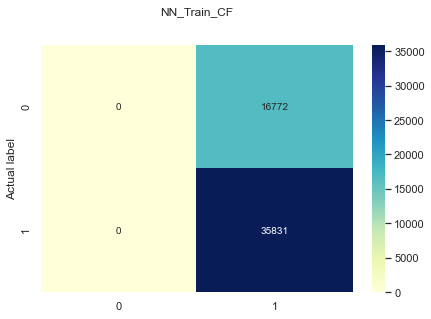

In [191]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(NN_Train_CNF ), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('NN_Train_CF', y=1.1)
plt.ylabel('Actual label')

In [192]:
ypred = model_nn.predict(Xtmpt)

#Create confusion matrix 
NN_Test_CNF = confusion_matrix(ytst, ypred)
NN_Test_CNF

print("NN Test DataSet Accuracy:",metrics.accuracy_score(ytst, ypred))
print("NN Test DataSet Precision:",metrics.precision_score(ytst, ypred))
print("NN Test DataSet Recall:",metrics.recall_score(ytst, ypred))
print("NN Test DataSet F1_Score:",metrics.f1_score(ytst, ypred))
print("NN Test DataSet AUC_Score:",metrics.roc_auc_score(ytst, ypred))


2500/2500 [==============================] - 18s 7ms/step
NN Test DataSet Accuracy: 0.56665
NN Test DataSet Precision: 0.56665
NN Test DataSet Recall: 1.0
NN Test DataSet F1_Score: 0.7233906743688762
NN Test DataSet AUC_Score: 0.5


Text(30.5, 0.5, 'Actual label')

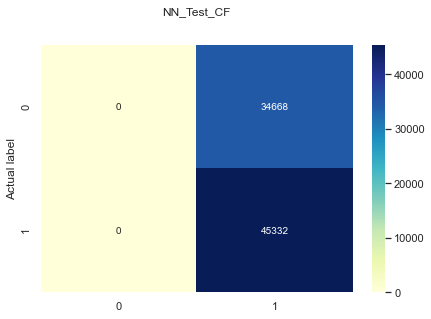

In [193]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(NN_Test_CNF ), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('NN_Test_CF', y=1.1)
plt.ylabel('Actual label')

In [194]:
print('Train loss:', score_nn[0])
print('Train accuracy:', score_nn[1])


Train loss: 0.0
Train accuracy: 0.6811588406562805


In [195]:
# NN Model test accuracy is evaluated as 0.55
score2_nn=model_nn.evaluate(Xtmpt,ytst,verbose=0)

In [196]:
# Printing the NN Model loss and accuracy
print('Test loss:', score2_nn[0])
print('Test accuracy:', score2_nn[1])


Test loss: 0.0
Test accuracy: 0.5666499733924866


# CNN MODEL

In [ ]:
#Import libraries
import pandas as pd
#importing numpy
import numpy as np
#importing tensorflow
import tensorflow as tf
#importing keras from tensorflow
from tensorflow import keras
# importing Sequential from keras
from tensorflow.keras.models import Sequential
#importing Dense and Conv2D layers from keras
from tensorflow.keras.layers import Dense,Conv1D

In [ ]:
# Define the CNN Model using a custom function build_model(hp)
# Four Convolution layers are considered

def build_model(hp):
    # create model object
    model = keras.Sequential([
    #additing input layer
    keras.layers.Dense(28, activation='relu', input_dim=28),
    keras.layers.Reshape((28,1)),
    #adding first convolutional layer    
    keras.layers.Conv1D(
        #adding filter 
        filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=16),
        # adding filter size or kernel size
        kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),
        #activation function
        activation='relu',
        input_shape=(28,28,1)),
    # adding second convolutional layer 
    keras.layers.Conv1D(
        #adding filter 
        filters=hp.Int('conv_2_filter', min_value=32, max_value=64, step=16),
        #adding filter size or kernel size
        kernel_size=hp.Choice('conv_2_kernel', values = [3,5]),
        #activation function
        activation='relu'
    ),
    # adding third convolutional layer 
    keras.layers.Conv1D(
        #adding filter 
        filters=hp.Int('conv_3_filter', min_value=32, max_value=64, step=16),
        #adding filter size or kernel size
        kernel_size=hp.Choice('conv_3_kernel', values = [3,5]),
        #activation function
        activation='relu'
    ),
        # adding fourth convolutional layer 
    keras.layers.Conv1D(
        #adding filter 
        filters=hp.Int('conv_4_filter', min_value=32, max_value=64, step=16),
        #adding filter size or kernel size
        kernel_size=hp.Choice('conv_4_kernel', values = [3,5]),
        #activation function
        activation='relu'
    ),
    # adding flatten layer    
    keras.layers.Flatten(),
    # adding dense layer    
    keras.layers.Dense(
        units=hp.Int('dense_1_units', min_value=32, max_value=128, step=16),
        activation='relu'
    ),
    # output layer    
    keras.layers.Dense(1, activation='softmax')
    ])
    #compilation of model
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    return model

In [ ]:
#importing random search from Kerastuners.tuners
from kerastuner import RandomSearch
#creating randomsearch object
tuner = RandomSearch(build_model,
                    objective='val_accuracy',
                    max_trials = 5,
                    directory = 'Tuning_CNN1',
                    overwrite=True
                   )
# search for best set of hyper parameters
tuner.search(X_train,y_train,epochs=3,validation_data=(X_test,y_test))

In [ ]:
# Best set of Hyper parameters are applied to the above CNN model 
# model is the CNN object, formed with best set of hyper parameters
model=tuner.get_best_models(num_models=1)[0]
#summary of best model
model.summary()


In [ ]:
# Train the model on X_train & y_train
model.fit(X_train,y_train,
          epochs=10,
          validation_split=0.1,initial_epoch=10)

In [ ]:
# Evaluate the CNN Model  Training 
score=model.evaluate(X_test,y_test,verbose=0)

In [ ]:
print('Train loss:', score[0])
print('Train  accuracy:', score[1])


In [ ]:
#Evaluate the CNN Model Test accuracy
score2=model.evaluate(Xtmpt,ytst,verbose=0)

In [ ]:
print('Test loss:', score2[0])
print('Test accuracy:', score2[1])
